In [1]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


In [5]:
client = tweepy.Client(bearer_token ='%')

In [6]:
query = '#RishiSunak -is:retweet lang:en'
paginator = tweepy.Paginator(
    client.search_recent_tweets,           
    query=query,                           
    max_results=100,                       
    limit=20)


tweet_list = []

for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)

In [7]:
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,What utter stupidity \n\nThis is the actual UK...
1,#Putin is a danger to world peace. He must be ...
2,"Sixth-former on secondment to #DowningStreet, ..."
3,"#Putin is destabilizing the world, like #Hitle..."
4,#China called on the #UK to stop its “politica...


In [8]:
def preprocess_tweet(sen):
    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    return sentence

In [9]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
     cleaned_tweet = preprocess_tweet(tweet)
     cleaned_tweets.append(cleaned_tweet)

In [10]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,What utter stupidity \n\nThis is the actual UK...,what utter stupidity this is the actual uk gov...
1,#Putin is a danger to world peace. He must be ...,putin is danger to world peace he must be sto...
2,"Sixth-former on secondment to #DowningStreet, ...",sixth former on secondment to downingstreet an...
3,"#Putin is destabilizing the world, like #Hitle...",putin is destabilizing the world like hitler ...
4,#China called on the #UK to stop its “politica...,china called on the uk to stop its political ...


In [11]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,What utter stupidity \n\nThis is the actual UK...,what utter stupidity this is the actual uk gov...,-0.058333,0.544444,negative,0.195,0.722,0.083,-0.7430
1,#Putin is a danger to world peace. He must be ...,putin is danger to world peace he must be sto...,0.000000,0.000000,negative,0.162,0.732,0.107,-0.2023
2,"Sixth-former on secondment to #DowningStreet, ...",sixth former on secondment to downingstreet an...,-0.125000,0.536111,negative,0.125,0.824,0.051,-0.5106
3,"#Putin is destabilizing the world, like #Hitle...",putin is destabilizing the world like hitler ...,0.000000,0.000000,positive,0.069,0.852,0.079,0.0772
4,#China called on the #UK to stop its “politica...,china called on the uk to stop its political ...,0.150000,0.175000,negative,0.212,0.740,0.048,-0.7096


Sentiment Visulization

In [12]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

In [13]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [14]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
negative,662,45.00
positive,504,34.26
neutral,305,20.73


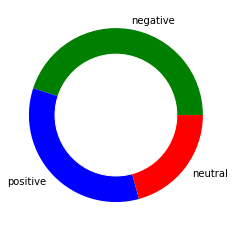

In [15]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()